In [1]:
!pip install -q torch torchvision timm scikit-learn matplotlib

In [2]:
ZIP_NAME = "Clinical Images.zip"
DATA_DIR_NAME = "Clinical Images"

# Parameters
EPOCHS = 20
BATCH_SIZE = 16
LR = 1e-4
PATIENCE = 3  # Early Stopping

In [4]:
import zipfile

ZIP_NAME = "Clinical Images.zip"

with zipfile.ZipFile(f"/content/{ZIP_NAME}", 'r') as z:
    z.extractall("/content")

DATA_DIR_NAME = "Clinical Images"

data_dir = f"/content/{DATA_DIR_NAME}"
print("Data directory:", data_dir)

!ls "$data_dir"
!ls -la "$data_dir" | head -n 20

Data directory: /content/Clinical Images
'Clinical Actinic Keratosis'	 'Clinical Pigmented Benign Keratosis'
'Clinical Basal Cell Carcinoma'  'Clinical Seborrheic Keratosis'
'Clinical Dermatofibroma'	 'Clinical Squamous Cell Carcinoma'
'Clinical Melanoma'		 'Clinical Vascular Lesion'
'Clinical Nevus'
total 60
drwxr-xr-x 11 root root  4096 Aug 23 16:08 .
drwxr-xr-x  1 root root  4096 Aug 23 16:08 ..
drwxr-xr-x  2 root root  4096 Aug 23 16:08 Clinical Actinic Keratosis
drwxr-xr-x  2 root root  4096 Aug 23 16:08 Clinical Basal Cell Carcinoma
drwxr-xr-x  2 root root  4096 Aug 23 16:08 Clinical Dermatofibroma
drwxr-xr-x  2 root root  4096 Aug 23 16:08 Clinical Melanoma
drwxr-xr-x  2 root root  4096 Aug 23 16:08 Clinical Nevus
drwxr-xr-x  2 root root  4096 Aug 23 16:08 Clinical Pigmented Benign Keratosis
drwxr-xr-x  2 root root  4096 Aug 23 16:08 Clinical Seborrheic Keratosis
drwxr-xr-x  2 root root  4096 Aug 23 16:08 Clinical Squamous Cell Carcinoma
drwxr-xr-x  2 root root  4096 Aug 23 16:0

In [5]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np, random

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.7 * len(full_dataset))
val_size   = int(0.15 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = full_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)
print(f"Total: {len(full_dataset)} | Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

Classes: ['Clinical Actinic Keratosis', 'Clinical Basal Cell Carcinoma', 'Clinical Dermatofibroma', 'Clinical Melanoma', 'Clinical Nevus', 'Clinical Pigmented Benign Keratosis', 'Clinical Seborrheic Keratosis', 'Clinical Squamous Cell Carcinoma', 'Clinical Vascular Lesion']
Total: 903 | Train: 632 | Val: 135 | Test: 136


In [6]:
import timm
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class HybridEffViT(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.cnn = timm.create_model(
            "efficientnet_b0", pretrained=True, num_classes=0, global_pool="avg"
        )
        self.vit = timm.create_model(
            "vit_base_patch16_224", pretrained=True, num_classes=0, global_pool="avg"
        )

        cnn_feat_dim = self.cnn.num_features
        vit_feat_dim = self.vit.num_features
        fusion_dim = cnn_feat_dim + vit_feat_dim

        self.head = nn.Sequential(
            nn.LayerNorm(fusion_dim),
            nn.Linear(fusion_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        z_cnn = self.cnn(x)  # [B, C_cnn]
        z_vit = self.vit(x)  # [B, C_vit]
        z = torch.cat([z_cnn, z_vit], dim=1)  # [B, C_cnn + C_vit]
        logits = self.head(z)                 # [B, num_classes]
        return logits

model = HybridEffViT(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

Device: cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [8]:
def evaluate_loader(model, loader, criterion, device):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return loss_sum / max(len(loader), 1), correct / total if total else 0.0

def train_model(model, epochs=EPOCHS, patience=PATIENCE):
    best_val_loss = float("inf")
    best_epoch = 0
    no_improve = 0
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        run_loss, correct, total = 0.0, 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            run_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = run_loss / max(len(train_loader), 1)
        train_acc = correct / total if total else 0.0

        val_loss, val_acc = evaluate_loader(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1:02d}/{epochs} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            no_improve = 0
            torch.save(model.state_dict(), "best_hybrid_effi_vit.pth")
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"⏹ Early stopping at epoch {epoch+1}. Best epoch: {best_epoch}")
                break

    print(f"Best epoch: {best_epoch} | Best Val Loss: {best_val_loss:.4f}")
    return history, best_epoch

history, best_epoch = train_model(model, epochs=EPOCHS, patience=PATIENCE)

Epoch 01/20 | Train Loss: 0.2353 Acc: 0.9478 | Val Loss: 0.1037 Acc: 0.9852
Epoch 02/20 | Train Loss: 0.0368 Acc: 0.9937 | Val Loss: 0.0423 Acc: 0.9926
Epoch 03/20 | Train Loss: 0.0089 Acc: 0.9984 | Val Loss: 0.0389 Acc: 0.9926
Epoch 04/20 | Train Loss: 0.0042 Acc: 1.0000 | Val Loss: 0.0419 Acc: 0.9926
Epoch 05/20 | Train Loss: 0.0063 Acc: 0.9968 | Val Loss: 0.0456 Acc: 0.9852
Epoch 06/20 | Train Loss: 0.0032 Acc: 1.0000 | Val Loss: 0.0409 Acc: 0.9852
⏹ Early stopping at epoch 6. Best epoch: 3
Best epoch: 3 | Best Val Loss: 0.0389


In [9]:
model.load_state_dict(torch.load("best_hybrid_effi_vit.pth", map_location=device))
test_loss, test_acc = evaluate_loader(model, test_loader, criterion, device)
print(f"[Test] Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

[Test] Loss: 0.0857 | Acc: 0.9926


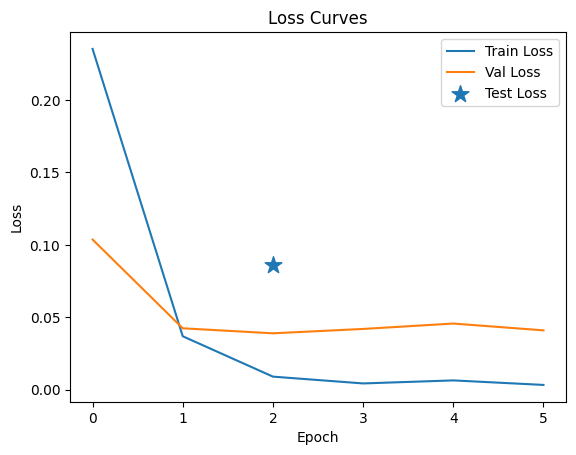

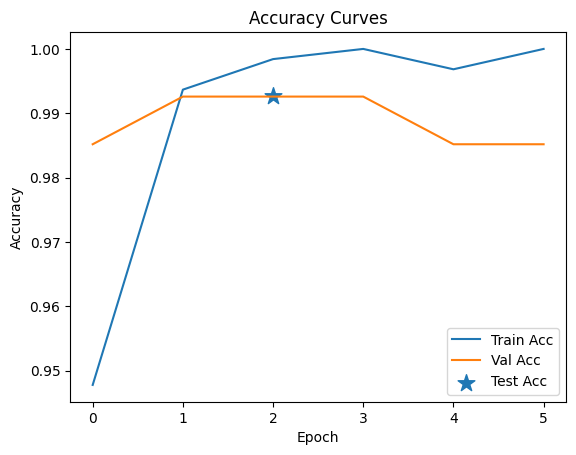

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"],   label="Val Loss")
plt.scatter([best_epoch-1], [test_loss], marker='*', s=160, label="Test Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curves"); plt.legend(); plt.show()

plt.figure()
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"],   label="Val Acc")
plt.scatter([best_epoch-1], [test_acc], marker='*', s=160, label="Test Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curves"); plt.legend(); plt.show()